# Deep Portfolio Optimization

Zhang, Zihao, Zohren, Stefan, and Roberts, Stephen (2020). Deep Learning for Portfolio Optimization. The Journal of Financial Data Science, 2(4), 8–20. With Intelligence LLC. https://doi.org/10.3905/jfds.2020.1.042

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import yfinance as yf
from torch.utils.data import Dataset, DataLoader,TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd 
import datetime

## Data

In [326]:
class ETFDataset(Dataset):
    def __init__(self,tickers,start,end,lookback=252,test_split=0.1,train=True):
        data = yf.download(tickers, start=start, end=end)['Close']
        ret = np.log1p(data.pct_change().dropna())
        data = data.loc[ret.index]
        dates = ret.index 

        N    = len(dates)
        split_idx  = int((1 - test_split) * N)
        if train:
            prices = data.iloc[:split_idx]
            rets   = ret.iloc[:split_idx]
        else:
            prices = data.iloc[split_idx:]
            rets   = ret.iloc[split_idx:]

        X, y = [], []
        for i in range(lookback, len(prices)):
            p = prices.iloc[i - lookback : i].values      # (lookback, n_assets)
            r = rets.iloc[i - lookback : i].values        # (lookback, n_assets)
            X.append(np.hstack([p, r]))                  # (lookback, 2*n_assets)
            y.append(rets.iloc[i].values)                     # (n_assets,)

        self.features = torch.tensor(np.stack(X), dtype=torch.float32)
        self.targets  = torch.tensor(np.stack(y), dtype=torch.float32)
       

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [327]:
tickers = ['VTI', 'AGG', 'DBC', '^VIX']
start = datetime.datetime(2006, 1, 1)
end   = datetime.datetime(2020, 12, 31)
train_ds = ETFDataset(tickers, start, end, lookback=50, test_split=0.1, train=True)
test_ds  = ETFDataset(tickers, start, end, lookback=50, test_split=0.1, train=False)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

/var/folders/m9/hllqwqb944vgcr87gbp44qp40000gn/T/ipykernel_79029/2258464235.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  4 of 4 completed
/var/folders/m9/hllqwqb944vgcr87gbp44qp40000gn/T/ipykernel_79029/2258464235.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  4 of 4 completed


## Objective Function

$$ L = \frac{E(R_p)}{Std(R_p)} $$

where $E(R_p)$ and $Std(R_p)$ are estimates of the mean and standard deviation of portfolio returns. 

Goal: Develop an LSTM network $f$ that maps current market information $x_t$ to portfolio weights $w_{i,t}= f(\theta \mid x_t)$, such that $\sum_i w_i = 1$, $w_i \in [0,1]$ 

## Model

In [328]:
#Objective Function: Maximize Sharpe Ratio
# L = \frac{E(R_p)}{Std(R_p)} 
def sharpe_ratio(weights, returns):
    port_rets = (weights * returns).sum(dim=1)
    mu = port_rets.mean()
    sigma = port_rets.std(unbiased=False) + 1e-6
    L = mu / sigma
    return L

In [329]:
class DeepPortfolio(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, sigma_tgt=1):
        super().__init__()
        self.n_assets  = input_dim // 2
        self.lstm      = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc        = nn.Linear(hidden_dim, self.n_assets)
        self.sigma_tgt = sigma_tgt

        nn.init.zeros_(self.fc.weight)  # start at uniform
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        """
        x: (batch, seq_len, 2 * n_assets)
           first half: prices, second half: returns
        """
        out, _ = self.lstm(x)                
        h    = out[:, -1, :]                  
        w    = torch.softmax(self.fc(h), dim=1)  

        # extract the returns window:
        rets = x[:, :, self.n_assets:]       
        vol  = rets.std(dim=1) + 1e-6        

        # scale & re-normalize
        w_scaled = w * (self.sigma_tgt / vol)     # (B, n_assets)
        w_scaled = w_scaled / w_scaled.sum(dim=1, keepdim=True)

        return w_scaled

## Training

In [330]:

input_dim = next(iter(train_loader))[0].shape[-1]  # e.g. 8
model     = DeepPortfolio(input_dim, hidden_dim=64, num_layers=1)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
num_epochs= 100

for epoch in range(1, num_epochs+1):
    model.train()
    running_sr = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch, y_batch

        optimizer.zero_grad()
        w    = model(X_batch)                      # (B, n_assets)
        sr   = sharpe_ratio(w, y_batch)
        loss = -sr                                  # minimize negative Sharpe
        loss.backward()
        optimizer.step()

        running_sr += sr.item()

    avg_sr = running_sr / len(train_loader)
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Avg Sharpe: {avg_sr:.4f}")

print("Training complete!")

Epoch 10 | Avg Sharpe: 0.1085
Epoch 20 | Avg Sharpe: 0.1455
Epoch 30 | Avg Sharpe: 0.1591
Epoch 40 | Avg Sharpe: 0.1744
Epoch 50 | Avg Sharpe: 0.1825
Epoch 60 | Avg Sharpe: 0.1936
Epoch 70 | Avg Sharpe: 0.2057
Epoch 80 | Avg Sharpe: 0.2119
Epoch 90 | Avg Sharpe: 0.2014
Epoch 100 | Avg Sharpe: 0.2028
Training complete!


## Evaluation

In [331]:
R_model, R_naive = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        w = model(X_batch)                            # (B, n_assets)
        r_model = (w * y_batch).sum(dim=1).cpu().numpy()  
        r_naive = y_batch.mean(dim=1).cpu().numpy()

        R_model.extend(r_model)
        R_naive.extend(r_naive)

R_model = np.array(R_model)   # shape (N_test,)
R_naive = np.array(R_naive)   # shape (N_test,)

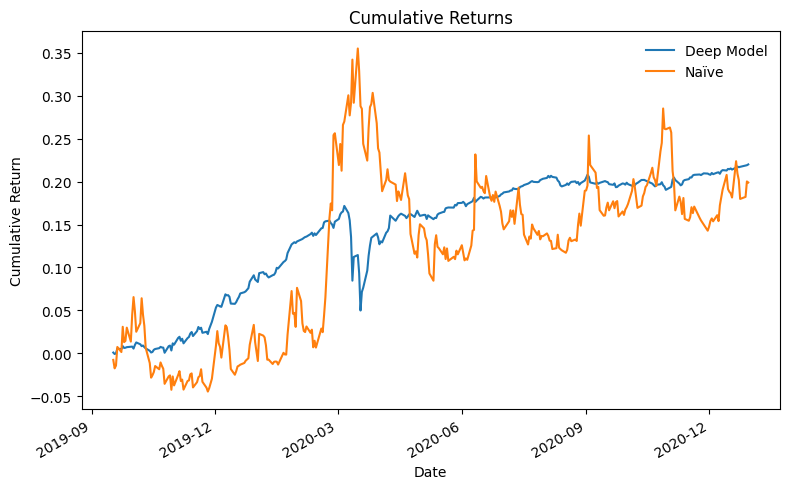

In [332]:
import matplotlib.dates as mdates

test_dates = prices.index[-len(R_model):]  # dates for the test period
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(test_dates, np.expm1(R_model.cumsum()), label='Deep Model')
ax.plot(test_dates, np.expm1(R_naive.cumsum()), label='Naïve')

# 1) choose tick spacing (e.g. every 3 months)
locator = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(locator)

# 2) choose tick label format
formatter = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(formatter)

# 3) rotate & align for readability
fig.autofmt_xdate()  # auto–rotates labels & adjusts bottom margin

ax.set_title('Cumulative Returns')
ax.set_ylabel('Cumulative Return')
ax.set_xlabel('Date')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

In [340]:
def calculate_annualized_sharpe(returns):
    """
    Calculate the annualized Sharpe ratio.
    Args:
        returns (np.ndarray): Daily log-returns of the portfolio
    """
    returns = np.expm1(returns)  # convert log-returns to simple returns
    mean_return = np.mean(returns)
    std_return  = np.std(returns, ddof=0)  # population std
    sharpe_ratio = mean_return / std_return * np.sqrt(252)  # daily to annual
    return sharpe_ratio

In [342]:


sharpe_model = calculate_annualized_sharpe(R_model)
sharpe_naive = calculate_annualized_sharpe(R_naive)

print(f"Ann. Return (Deep): {np.expm1(R_model.mean() * 252):.2%} | Sharpe: {sharpe_model:.2f}")  
print(f"Ann. Return (Naïve): {np.expm1(R_naive.mean() * 252):.2%} | Sharpe: {sharpe_naive:.2f}")

Ann. Return (Deep): 16.62% | Sharpe: 1.88
Ann. Return (Naïve): 15.06% | Sharpe: 0.66
